In [2]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist

# 데이터 준비
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images.reshape(-1, 28 * 28) / 255.0

# 모델 불러오기
model = tf.keras.models.load_model('./weight/model.h5')

# 레이어 객체
hidden2_layer = model.layers[1]  # 두 번째 히든 레이어
output_layer = model.layers[2]   # 출력 레이어

# 중간 입력값 추출 모델
hidden2_input_model = tf.keras.Model(inputs=model.input, outputs=hidden2_layer.input)
output_input_model = tf.keras.Model(inputs=model.input, outputs=output_layer.input)

# 전체 테스트셋에 대해 추출
hidden2_inputs = hidden2_input_model.predict(test_images, verbose=1)  # shape: (10000, 300)
output_inputs = output_input_model.predict(test_images, verbose=1)    # shape: (10000, 100)

# 라벨별로 그룹화하여 통계 계산
num_classes = 10
hidden2_stats = {}
output_stats = {}

for label in range(num_classes):
    idx = np.where(test_labels == label)[0]
    hidden2_group = hidden2_inputs[idx]   # shape: (N, 300)
    output_group = output_inputs[idx]     # shape: (N, 100)
    
    # 예시: 평균과 분산 계산
    hidden2_stats[label] = {
        'mean': np.mean(hidden2_group, axis=0),
        'std': np.std(hidden2_group, axis=0)
    }
    output_stats[label] = {
        'mean': np.mean(output_group, axis=0),
        'std': np.std(output_group, axis=0)
    }

# 예시: 0번 라벨의 2번째 히든 레이어 입력값 평균 shape
print("0번 라벨의 2번째 히든 레이어 입력값 평균 shape:", hidden2_stats[0]['mean'].shape)
print("0번 라벨의 출력 레이어 입력값 평균 shape:", output_stats[0]['mean'].shape)

313/313 [==============================] - 0s 441us/step
0번 라벨의 2번째 히든 레이어 입력값 평균 shape: (300,)
0번 라벨의 출력 레이어 입력값 평균 shape: (100,)


In [3]:
# 첫 번째, 두 번째 히든 레이어의 출력값 추출 모델
hidden1_output_model = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)
hidden2_output_model = tf.keras.Model(inputs=model.input, outputs=model.layers[1].output)

hidden1_outputs = hidden1_output_model.predict(test_images)
hidden2_outputs = hidden2_output_model.predict(test_images)

313/313 [==============================] - 0s 423us/step


# 각 레이블 0~9에 따른 두 히든 레이어의 합의 분포

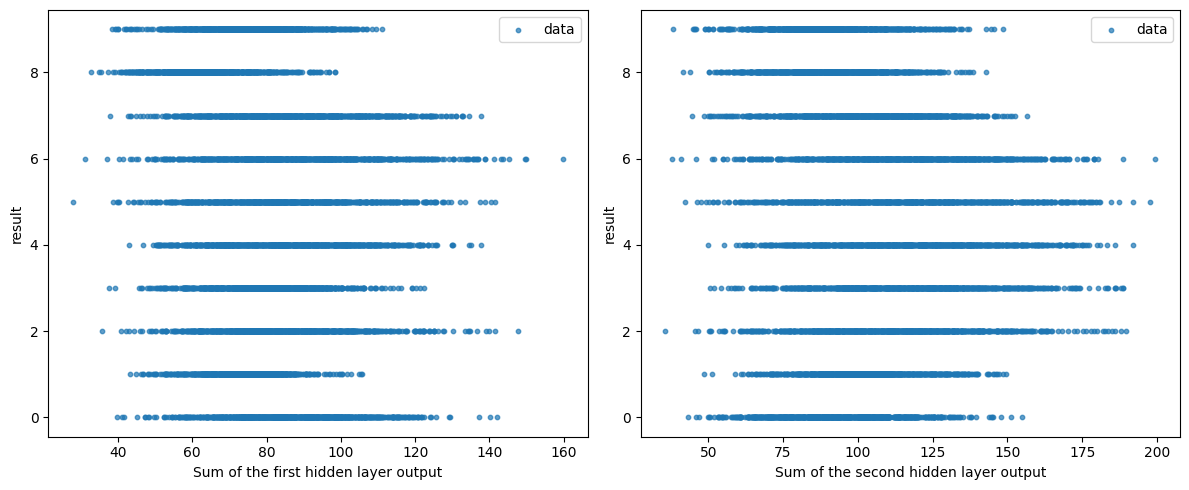

In [4]:
import matplotlib.pyplot as plt

# hidden1_outputs, hidden2_outputs: 각 히든 레이어의 출력값 (예: (10000, 300), (10000, 100))
# test_labels: (10000,)

# 첫 번째 히든 레이어 출력값 합
hidden1_sum = np.sum(hidden1_outputs, axis=1)  # (10000,)
# 두 번째 히든 레이어 출력값 합
hidden2_sum = np.sum(hidden2_outputs, axis=1)  # (10000,)

plt.figure(figsize=(12, 5))

# 첫 번째 히든 레이어 출력값 합 vs 라벨
plt.subplot(1, 2, 1)
plt.scatter(hidden1_sum, test_labels, label='data', alpha=0.7, s=10)
plt.xlabel('Sum of the first hidden layer output')
plt.ylabel('result')
plt.legend()

# 두 번째 히든 레이어 출력값 합 vs 라벨
plt.subplot(1, 2, 2)
plt.scatter(hidden2_sum, test_labels, label='data', alpha=0.7, s=10)
plt.xlabel('Sum of the second hidden layer output')
plt.ylabel('result')
plt.legend()

plt.tight_layout()
plt.show()

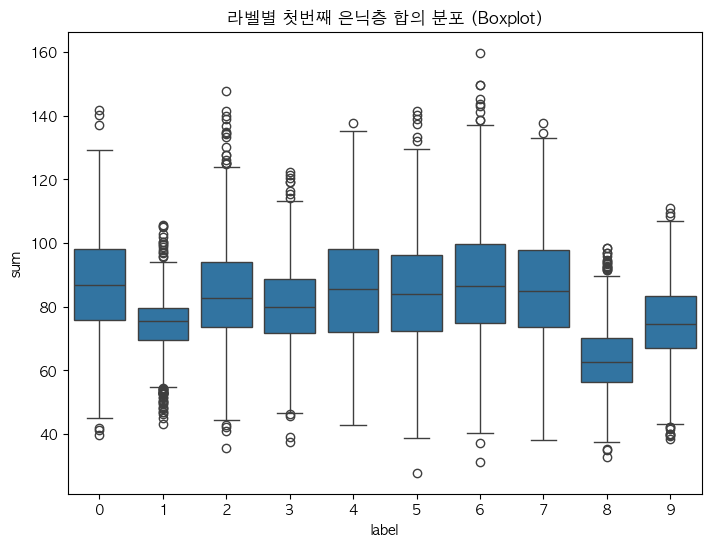

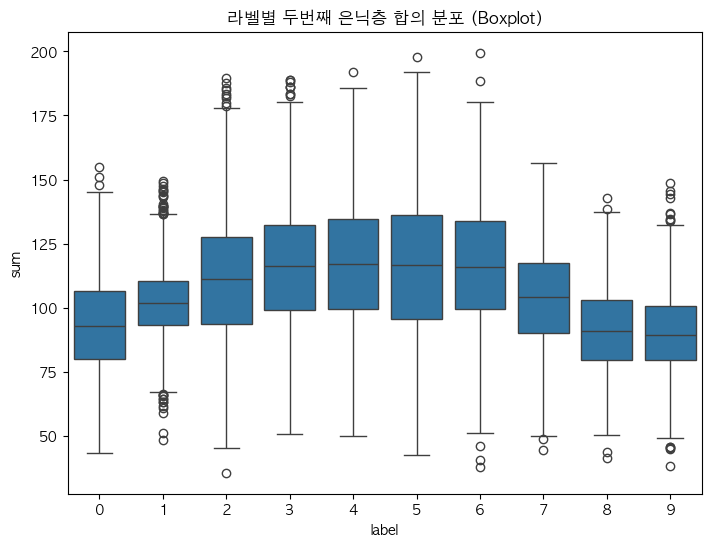

In [14]:
import seaborn as sns
import pandas as pd
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

df1 = pd.DataFrame({'sum': hidden1_sum, 'label': test_labels})
df2 = pd.DataFrame({'sum': hidden2_sum, 'label': test_labels})

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='sum', data=df1)
plt.title('라벨별 첫번째 은닉층 합의 분포 (Boxplot)')
plt.show()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='sum', data=df2)
plt.title('라벨별 두번째 은닉층 합의 분포 (Boxplot)')
plt.show()

### ANOVA(분산분석, Analysis of Variance)
여러 그룹(여기서는 라벨별) 간 평균의 차이가 통계적으로 유의미한지 검정합니다.

귀무가설: 모든 라벨 그룹의 은닉층 합 평균이 같다.

대립가설: 적어도 한 그룹의 평균이 다르다.

p-value가 0.05보다 작으면 라벨별로 유의미한 차이가 있다고 볼 수 있습니다.

In [15]:
from scipy.stats import f_oneway

# 라벨별로 은닉층 합 분리
grouped1 = [hidden1_sum[test_labels == i] for i in range(10)]
f_stat, p_value = f_oneway(*grouped1)
print(f"F-통계량: {f_stat}, p-value: {p_value}")

grouped2 = [hidden2_sum[test_labels == i] for i in range(10)]
f_stat, p_value = f_oneway(*grouped2)
print(f"F-통계량: {f_stat}, p-value: {p_value}")

F-통계량: 263.062247482315, p-value: 0.0
F-통계량: 262.5845819214439, p-value: 0.0
